### Imports 

In [ ]:
from google.colab import files
from drive.MyDrive.simple_model_definition import networkLinear, LinearBlock, identityNN
from drive.MyDrive.gev_loss import simpleGEVloss
from drive.MyDrive.dataloaders import BaseDataLoader, DataLoader2
from drive.MyDrive.training_modules import NeuralTrainer, Diagnostic
from drive.MyDrive.schedulers import CyclicCosAnnealingLR, CyclicLinearLR
from drive.MyDrive.models_class1 import ModuleCustom, Model_unique_station

In [ ]:
import numpy as np
import pandas as pd
import scipy as sc
import torch
import matplotlib.pyplot as plt
import scipy

import math
import time
import numpy as np

import torch
import torch.nn as nn
from torch.nn import LSTM
import torch.nn.functional as F

from torch.autograd import Variable
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.optimizer import Optimizer

from statsmodels.distributions.empirical_distribution import ECDF

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
monthly_maxima = pd.read_csv("/content/drive/MyDrive/data_monthly.csv")
monthly_maxima.drop("Unnamed: 0", inplace = True, axis=1)
monthly_maxima

,id,year,month,dur,int,X,Y,basin,alt
0,69505,1996,Jan,5,40.800,-84.148057,10.165240,69,1899
1,69505,1997,Jan,5,24.000,-84.148057,10.165240,69,1899
2,69505,1998,Jan,5,1.200,-84.148057,10.165240,69,1899
3,69505,1999,Jan,5,13.200,-84.148057,10.165240,69,1899
4,69505,2000,Jan,5,37.200,-84.148057,10.165240,69,1899
...,...,...,...,...,...,...,...,...,...
359203,98080,2016,Dec,1440,0.846,-83.386662,9.080118,98,434
359204,98080,2017,Dec,1440,0.296,-83.386662,9.080118,98,434
359205,98080,2018,Dec,1440,1.408,-83.386662,9.080118,98,434
359206,98080,2019,Dec,1440,0.404,-83.386662,9.080118,98,434


In [ ]:
stations_training_testing = pd.read_csv("/content/drive/MyDrive/data_training_testing.csv")
stations_training_testing.drop("Unnamed: 0", inplace = True, axis=1)

list_stations_training = list(stations_training_testing[stations_training_testing["train"] == True]["id"].values)
list_stations_testing = list(stations_training_testing[stations_training_testing["train"] == False]["id"].values)
print(*list_stations_training, sep = ", ")
print("----------")
print(*list_stations_testing, sep = ", ")

73046, 78020, 98015, 69576, 98043, 69654, 79012, 84122, 84136, 88028, 76012, 69524, 84124, 69698, 73124, 88034, 79020, 69542, 88018, 69522, 69700, 73055, 98023, 98021, 75028, 73098, 88024, 73074, 98057, 98050, 88032, 79010, 98020, 69544, 69628, 98059, 69624, 76033, 76050, 69670, 69570, 69547, 98036, 98039, 94014, 73042, 75007, 84043, 69530, 69694, 84130, 69662, 76048, 69632, 75004, 69598, 69596, 69581, 69553, 84034, 74036, 69563, 69612, 76006, 98037, 79014, 74019, 69630, 69696, 69668, 69604, 73134, 69550, 84096, 69571, 76044, 76018, 73028, 69686, 78018, 73140, 69532, 76024, 98058, 69572, 76020, 73079, 75003, 98044, 98034, 69505, 73128, 76013, 69552, 75005, 98019, 76021, 98012, 98080, 98078, 88020, 87010, 76038, 69548, 69545, 88023, 69574, 73027, 69549, 69636, 69561, 98011, 84114, 98040, 69520, 76022, 88030, 78002, 73148, 76036, 75002, 73047, 69578
----------
69507, 69551, 69582, 69583, 69587, 69588, 69589, 69608, 69614, 69616, 69620, 69626, 69634, 69638, 69656, 69674, 69682, 73011, 730

In [ ]:
durations = list(set(monthly_maxima["dur"]))
station_ids = list(set(monthly_maxima["id"]))
monthly_maxima["int_frechet"] = np.Inf
for dur in range(len(durations)):
  for id in range(len(station_ids)):
    mask = (monthly_maxima["dur"] == durations[dur]) & (monthly_maxima["id"] == station_ids[id])
    ecdf = ECDF(monthly_maxima[mask]["int"])
    monthly_maxima.loc[mask, "int_frechet"] = monthly_maxima[mask]["int"].apply(lambda x: -1/np.log(ecdf(x)))
    
mask = monthly_maxima['int_frechet'] != -np.inf
monthly_maxima.loc[~mask, 'int_frechet'] = monthly_maxima.loc[mask, 'int_frechet'].min()

In [ ]:
# ecdf = ECDF(monthly_maxima["int"])
# monthly_maxima["int_frechet"] = -1 / np.log(ecdf(monthly_maxima["int"]))
# mask = monthly_maxima['int_frechet'] != -np.inf
# monthly_maxima.loc[~mask, 'int_frechet'] = monthly_maxima.loc[mask, 'int_frechet'].min()
# min(monthly_maxima["int_frechet"])

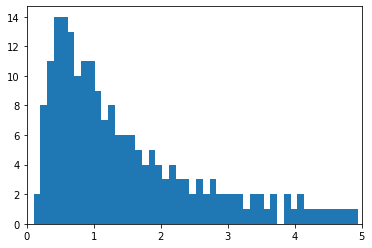

In [ ]:
mask = (monthly_maxima["dur"] == 1440) & (monthly_maxima["id"] == 75022)
plt.hist(monthly_maxima.loc[mask, "int_frechet"], bins = np.linspace(0, 10, 100))
plt.xlim((0, 5))
plt.show()

In [ ]:
# from sklearn.model_selection import train_test_split

# name_covariates = ["X", "Y", "alt", "dur"]
# for j in range(order_basis):
#   name_covariates.append('month_cos_'+str(j))
#   name_covariates.append('month_sin_'+str(j))

# X_input = monthly_maxima_labelMonth[name_covariates]
# Y_output = monthly_maxima_labelMonth["int_frechet"]
# X_train, X_test, y_train, y_test = train_test_split(X_input,Y_output,test_size=0.2,random_state=42)
# print(X_train)

# from sklearn.preprocessing import MinMaxScaler
# pd.options.mode.chained_assignment = None  # default='warn'

# scaler = MinMaxScaler()

# X_train.loc[:, ['X', 'Y', 'alt']] = scaler.fit_transform(X_train[['X', 'Y', 'alt']])
# X_test.loc[:, ['X', 'Y', 'alt']] = scaler.transform(X_test[['X', 'Y', 'alt']])
# # X_train_tensor = torch.from_numpy(X_train.to_numpy())
# # y_train_tensor = torch.from_numpy(y_train.to_numpy())
# # X_test_tensor = torch.from_numpy(X_test.to_numpy())
# # y_test_tensor = torch.from_numpy(y_test.to_numpy())
# print(X_train)

### Data loader for the complex model

In [ ]:
class DataLoader3(BaseDataLoader):
    """ Assumption: dataInput and dataOutput are pd.DataFrame in this case. Also, 
    """

    def __init__(self, 
                 data_DF, 
                 batch_size, 
                 maxIterations = None, 
                #  number_stations_tot = None, 
                #  min_ratio_obs = 0.2, 
                #  max_ratio_obs = 0.8, 
                #  fixed_ratio = None,
                 mixed_column_names = None, 
                 column_name_input = None, 
                 column_name_output = None,
                 column_name_check = None,
                 value_check = None,
                 symmetric_samples = True,
                 ):
        # if number_stations_tot is not None: assert number_stations_tot > 1, "number_stations_tot needs to be greater than 1"

        # self.number_stations_tot = number_stations_tot # if None, then all observations are used (such that they each have same values for fixed_columns_names)
        # self.min_ratio_obs = min(min_ratio_obs, max_ratio_obs)
        # self.max_ratio_obs = max(max_ratio_obs, min_ratio_obs)
        # self.fixed_ratio = fixed_ratio
        self.mixed_column_names = mixed_column_names

        if self.mixed_column_names is None:
          self.mixed_column_names = dataInput.columns
        self.fixed_columns_names = list(set(data_DF.columns) - set(self.mixed_column_names))

        self.column_name_input = column_name_input
        self.column_name_output = column_name_output

        self.column_name_check = column_name_check
        self.value_check = value_check
        if self.column_name_check is not None: assert self.value_check is not None
        if self.value_check is not None: assert self.column_name_check is not None
        if self.column_name_check is not None: assert self.column_name_check in self.mixed_column_names

        self.DF_split = [y for x, y in data_DF.groupby(self.fixed_columns_names)]
        if self.column_name_check is not None:
          self.DF_split = [df for df in self.DF_split if self.value_check in df[self.column_name_check].values]
        self.DF_split = [df for df in self.DF_split if len(df)>1] # avoid observations with only one station...

        self.batch_size = batch_size
        self.count = 0
        self.nb_epoch = 0
        self.maxIterations = maxIterations
        if self.maxIterations is None:
            self.maxIterations = np.Inf

        self.symmetric_samples = symmetric_samples
    
    def __iter__(self):
        return self
    
    def __next__(self):
        self.count += 1
        if self.count > self.maxIterations:
            raise StopIteration
        return self.sample()
        
    def reset(self):
        self.count = 0
    

    def sample(self, verbose = False):
      return self.getSample(self.batch_size, verbose = verbose)

    def getSample(self, size = 1, verbose = False):
      chosen_subsets = np.random.choice(len(self.DF_split), size = size, replace = True)
      x1_list = []
      x2_list = []

      if verbose:
        iterator = tqdm(range(len(chosen_subsets)))
      else:
        iterator = range(len(chosen_subsets))
        
      for sub in iterator:
        df = self.DF_split[chosen_subsets[sub]]
        if self.column_name_check is not None:
          x1_list.append(df[df[self.column_name_check] == self.value_check].sample())
          x2_list.append(df[df[self.column_name_check] != self.value_check].sample())
        else:
          # x1_list.append(df.sample())
          # x2_list.append(df.sample())
          df_sample = np.random.choice(len(df), size = 2, replace = False)
          x1_list.append(df.iloc[df_sample[0],:])
          x2_list.append(df.iloc[df_sample[1],:])

        if self.symmetric_samples:
          l1_last = x1_list[-1]
          x1_list.append(x2_list[-1])
          x2_list.append(l1_last)

      if self.column_name_check is not None:
        inputsx1 = pd.concat(x1_list)
        inputsx2 = pd.concat(x2_list)
      else:
        inputsx1 = pd.concat(x1_list, axis = 1).transpose()
        inputsx2 = pd.concat(x2_list, axis = 1).transpose()
        
      input_batch_covariates1 = torch.from_numpy(inputsx1[self.column_name_input].to_numpy())
      input_batch_covariates2 = torch.from_numpy(inputsx2[self.column_name_input].to_numpy())
      output_batch_int1 = torch.from_numpy(inputsx1[self.column_name_output].to_numpy())
      output_batch_int2 = torch.from_numpy(inputsx2[self.column_name_output].to_numpy())

      return {"input": {"cov1": input_batch_covariates1, 
                        "cov2": input_batch_covariates2},
              "output": {"int1": output_batch_int1,
                         "int2": output_batch_int2}
              }

    def sample_pair(self, val_1, val_2, column_name_check = None, size=None):
      if column_name_check is None: assert self.column_name_check is not None

      DF_split_v = [df for df in self.DF_split if (val_1 in df[column_name_check].values) & (val_2 in df[column_name_check].values)]
      # print(DF_split_v)
      if size is not None:
        chosen_subsets = np.random.choice(len(DF_split_v), size = size, replace = True)
      else:
        chosen_subsets = np.arange(len(DF_split_v))
      x1_list = []
      x2_list = []
      for sub in range(len(chosen_subsets)):
        df = DF_split_v[chosen_subsets[sub]]
        x1_list.append(df[df[column_name_check] == val_1].sample())
        x2_list.append(df[df[column_name_check] == val_2].sample())

        if self.symmetric_samples:
          l1_last = x1_list[-1]
          x1_list.append(x2_list[-1])
          x2_list.append(l1_last)

      inputsx1 = pd.concat(x1_list)
      inputsx2 = pd.concat(x2_list)
      input_batch_covariates1 = torch.from_numpy(inputsx1[self.column_name_input].to_numpy())
      input_batch_covariates2 = torch.from_numpy(inputsx2[self.column_name_input].to_numpy())
      output_batch_int1 = torch.from_numpy(inputsx1[self.column_name_output].to_numpy())
      output_batch_int2 = torch.from_numpy(inputsx2[self.column_name_output].to_numpy())

      return {"input": {"cov1": input_batch_covariates1, 
                        "cov2": input_batch_covariates2},
              "output": {"int1": output_batch_int1,
                         "int2": output_batch_int2}
              }

### setting

In [ ]:
# Settings
Station_of_interest = 69507          # if None, all station used
Second_station_of_interest = None    # if None, Station_of_interest vs all others. Otherwise, Station_of_interest vs Second_station_of_interest
Duration_of_interest = "all"         # if "all", all durations are used. Otherwise, must be amond [5, 10, ..., 1440]

# Training
Proportion_of_stations_test = 0.1    # ~ 16 stations will be used as validation
Train_dataset_relative_size = 0.8    # 80% of observation is used for training
Nb_time_dataset_is_recreated = 10    # retrain model 10 times on a new dataset, following previous settings
Nb_bootstrapping = 5                 # for each dataset, fit model 5 times (potentially using residual bootstrapping or something similar)

Order_basis = 2
use_seed = None

if Station_of_interest is not None and Second_station_of_interest is not None:
  Proportion_of_stations_test = 0.0
  print("Proportion_of_stations_test set to 0, as 'Station_of_interest' and 'Second_station_of_interest' where provided.")

if Station_of_interest is None and Second_station_of_interest is not None:
  Station_of_interest, Second_station_of_interest = Second_station_of_interest, Station_of_interest
  print("Setting Station_of_interest as Second_station_of_interest, and Second_station_of_interest as None")

In [ ]:
all_stations = sorted(list(set(monthly_maxima["id"])))
all_durations = sorted(list(set(monthly_maxima["dur"])))
assert Station_of_interest in all_stations or Station_of_interest is None, "Station_of_interest must be None or from the list of stations available."
assert Second_station_of_interest in all_stations or Second_station_of_interest is None, "Second_station_of_interest must be None or from the list of stations available."
assert Duration_of_interest in all_durations or Duration_of_interest == "all", "Duration_of_interest must be 'all' or from the list of durations available."

print(*all_stations, sep=', ')
print(*all_durations, sep=', ')

69505, 69507, 69520, 69522, 69524, 69530, 69532, 69542, 69544, 69545, 69547, 69548, 69549, 69550, 69551, 69552, 69553, 69561, 69563, 69570, 69571, 69572, 69574, 69576, 69578, 69581, 69582, 69583, 69587, 69588, 69589, 69596, 69598, 69604, 69608, 69612, 69614, 69616, 69620, 69624, 69626, 69628, 69630, 69632, 69634, 69636, 69638, 69654, 69656, 69662, 69668, 69670, 69674, 69682, 69686, 69694, 69696, 69698, 69700, 73011, 73027, 73028, 73033, 73042, 73046, 73047, 73055, 73074, 73079, 73084, 73098, 73112, 73116, 73124, 73126, 73128, 73134, 73136, 73140, 73148, 74019, 74036, 75002, 75003, 75004, 75005, 75007, 75022, 75028, 76006, 76012, 76013, 76018, 76020, 76021, 76022, 76024, 76026, 76033, 76034, 76036, 76038, 76044, 76048, 76050, 77001, 78002, 78012, 78018, 78020, 79010, 79012, 79014, 84034, 84043, 84063, 84096, 84114, 84116, 84118, 84120, 84122, 84124, 84130, 84136, 87010, 88018, 88020, 88023, 88024, 88026, 88028, 88030, 88032, 88034, 88040, 94014, 98006, 98011, 98012, 98015, 98017, 98019,

In [ ]:
def create_dataloader(DF_train, columns_in, s1, s2, dur, name_covariates):
    DF_train_ = DF_train[columns_in]
    if s1 is not None and s2 is not None:
      DF_train_ = DF_train_[(DF_train_["id"] == s1) | (DF_train_["id"] == s2)]
    if dur is not "all":
      DF_train_ = DF_train_[(DF_train_["dur"] == dur)]

    DF_train_['dur'] = np.log(DF_train_['dur'])

    if s1 is not None and s2 is None:
      value_check = s1

    dataloader_Training = DataLoader3(
      data_DF = DF_train_, 
      maxIterations = None, 
      mixed_column_names = ["X", "Y", "alt", "int_frechet", "id", "int"], 
      column_name_input = name_covariates, 
      column_name_output = ["int_frechet"],
      column_name_check = "id" if s1 is not None and s2 is None else None,
      value_check = s1 if s1 is not None and s2 is None else None,
      batch_size = 5,
      symmetric_samples = False,
    )
    return dataloader_Training

def create_training_datasets(data_input, train_size, proportion_station_train, inputs_columns, name_covariates,
                             seed_val = None, station1 = None, station2 = None, duration = None):
  column_names = list(data_input.columns)
  assert all([c in column_names for c in ["X", "Y", "alt", "dur", "int_frechet", "int", "id"]]), "Unknown column name provided ! (Custom error)"

  # Step 1: remove random stations from the dataset
  list_stations = sorted(list(set(data_input["id"])))
  repeat_sampling = True
  while repeat_sampling:
    indices = np.random.choice(len(list_stations), size = int(len(list_stations) * proportion_station_train), replace = False)
    list_stations_training = [list_stations[i] for i in indices]
    if station1 is not None and station2 is None and station1 not in list_stations_training:
      repeat_sampling = True
      print("Repeating...")
    else:
      repeat_sampling = False

  mask = data_input['id'].isin(list_stations_training)
  data_input_station_training, data_input_station_testing = data_input[mask], data_input[~mask]

  if station1 is not None and station2 is not None:
    assert station1 in list_stations_training and station2 in list_stations_training
    assert data_input_station_testing.empty

  if station1 is not None and station2 is None:
    data_input_station_testing = pd.concat([data_input_station_testing, data_input[data_input['id'] == station1]])

  X_train1, X_test1 = train_test_split(data_input_station_training, 
                                       test_size = 1.0-train_size,
                                       random_state = seed_val)
  
  scaler = MinMaxScaler()
  X_train1.loc[:, ['X', 'Y', 'alt']] = scaler.fit_transform(X_train1[['X', 'Y', 'alt']])
  X_test1.loc[:, ['X', 'Y', 'alt']] = scaler.transform(X_test1[['X', 'Y', 'alt']])
  if not data_input_station_testing.empty:
    data_input_station_testing.loc[:, ['X', 'Y', 'alt']] = scaler.transform(data_input_station_testing[['X', 'Y', 'alt']])


  dataloader_Training_1 = create_dataloader(X_train1, inputs_columns, station1, station2, duration, name_covariates)
  dataloader_Testing_1 = create_dataloader(X_test1, inputs_columns, station1, station2, duration, name_covariates)

  if not data_input_station_testing.empty:
    dataloader_Testing_missing_stations = create_dataloader(data_input_station_testing, inputs_columns, station1, station2, duration, name_covariates)
  else:
    dataloader_Testing_missing_stations = None

  return dataloader_Training_1, dataloader_Testing_1, dataloader_Testing_missing_stations, scaler, list_stations_training

In [ ]:
# TODO: try to multiply at the end r with a quantity depending on the distance between two stations, so that when distance is 0, 
# r will correspond to the perfectly dependent case

import warnings
warnings.filterwarnings("ignore")

monthly_maxima_labelMonth = monthly_maxima.copy()
look_up = {'01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr', '05': 'May',
            '06': 'Jun', '07': 'Jul', '08': 'Aug', '09': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}
look_up_inv = {v: int(i) for i, (k, v) in enumerate(look_up.items())}
monthly_maxima_labelMonth['month'] = monthly_maxima_labelMonth['month'].map(look_up_inv)

for j in range(Order_basis):
    monthly_maxima_labelMonth['month_cos_'+str(j)] = np.cos((j+1)*2*np.pi * monthly_maxima_labelMonth['month'] / 12)
    monthly_maxima_labelMonth['month_sin_'+str(j)] = np.sin((j+1)*2*np.pi * monthly_maxima_labelMonth['month'] / 12)
# monthly_maxima_labelMonth = monthly_maxima_labelMonth.loc[(monthly_maxima_labelMonth.loc[:,'id'] == station_of_interest), :]
# monthly_maxima_labelMonth

name_covariates = ["X", "Y", "alt", "dur"]
for j in range(Order_basis):
  name_covariates.append('month_cos_'+str(j))
  name_covariates.append('month_sin_'+str(j))
inputs_columns = name_covariates.copy()
inputs_columns.extend(["year", "int_frechet", "month", "id", "int"])

if Station_of_interest not in list_stations_training:
  list_stations_training.append(Station_of_interest)

if Second_station_of_interest is not None and Second_station_of_interest not in list_stations_training:
  list_stations_training.append(Second_station_of_interest)

data_in = monthly_maxima_labelMonth[monthly_maxima_labelMonth["id"].isin(list_stations_training)]

d1, d2, d3, scaler, list_stations_training = create_training_datasets(
                                      data_input = data_in, 
                                      train_size = Train_dataset_relative_size, 
                                      proportion_station_train = 1.0 - Proportion_of_stations_test, 
                                      inputs_columns = inputs_columns, 
                                      name_covariates = name_covariates,
                                      seed_val = 42, 
                                      station1 = Station_of_interest, 
                                      station2 = Second_station_of_interest, 
                                      duration = Duration_of_interest)

In [ ]:
data_frame_station_attributes = []
for station in all_stations:
  data_frame_station_attributes.append(monthly_maxima[monthly_maxima["id"] == station][["X", "Y", "alt", "id"]].iloc[0,:])

data_frame_station_attributes = pd.concat(data_frame_station_attributes, axis=1).transpose()
data_frame_station_attributes['id'] = data_frame_station_attributes['id'].astype(int)
data_frame_station_attributes.set_index("id", inplace = True)

data_frame_station_attributes_rescaled = scaler.transform(data_frame_station_attributes)
data_frame_station_attributes_rescaled = pd.DataFrame(data_frame_station_attributes_rescaled, index = data_frame_station_attributes.index)

# data_frame_station_attributes
# data_frame_station_attributes_rescaled

In [ ]:
# d1.getSample(size = 4)

In [ ]:
# plt.hist(monthly_maxima_labelMonth["int_frechet"], bins = np.linspace(0, 10, 100))
# plt.xlim((0, 5))
# plt.show()
# # Still ok :)

### Model

In [ ]:
class logistic_dep_loss(nn.Module):
  def __init__(self):
    super(logistic_dep_loss, self).__init__()

  def forward(self, r, int1, int2):
    sum_int_w = int1**r + int2**r
    A = sum_int_w**(1/r) + r - 1
    B = (int1*int2)**(r-1)
    C = sum_int_w**(-2 + 1/r)
    return -torch.sum(torch.log(A) + torch.log(B) + torch.log(C) - (sum_int_w**(1/r)))/r.shape[0]


class neg_logistic_dep_loss(nn.Module):
  def __init__(self):
    super(neg_logistic_dep_loss, self).__init__()

  def forward(self, r, int1, int2):
    inverse_r = 1/r
    sum_int_w = int1**(-r) + int2**(-r)

    deriv_V_1 = 1 - sum_int_w**(-inverse_r-1) * (int1)**(-r - 1)
    deriv_V_2 = 1 - sum_int_w**(-inverse_r-1) * (int2)**(-r - 1)

    second_deriv_V_p1 = -((int1*int2)**(-r - 1)) * (r+1)
    second_deriv_V_p2 = (sum_int_w**(-inverse_r-2)) 
    
    final1 = (deriv_V_1*deriv_V_2 - second_deriv_V_p1*second_deriv_V_p2)
    # final1 = torch.max(final1 - 1e-5,torch.tensor([0.])) + 1e-5
    V = int1 + int2 - sum_int_w**(-inverse_r)
    # print(min(final1), max(final1))
    
    return -torch.sum(torch.log(final1) - V)/final1.shape[0]


class Husler_Reiss_dep_loss(nn.Module):
  def __init__(self):
    super(Husler_Reiss_dep_loss, self).__init__()
    self.nn_distr = torch.distributions.normal.Normal(0, 1)

  def forward(self, r, int1, int2):
    A = 1/r + 0.5*r*torch.log(int1/int2)
    B = 1/r + 0.5*r*torch.log(int2/int1)
    deriv_B_1 = -0.5*r/int1
    deriv_A_2 = -0.5*r/int2
    deriv_B_2 = 0.5*r/int2
    deriv_A_1 = 0.5*r/int1
    V = int1 * self.nn_distr.cdf(A) + int2*self.nn_distr.cdf(B)

    deriv_V_1 = self.nn_distr.cdf(A) + 0.5*r*self.n_pdf(A) + int2*self.n_pdf(B)*deriv_B_1
    deriv_V_2 = self.nn_distr.cdf(B) + 0.5*r*self.n_pdf(B) + int1*self.n_pdf(A)*deriv_A_2

    deriv_V_12 = -0.5*r*(self.n_pdf(B)/int1 + self.n_pdf(A)/int2 + 0.5*r*self.deriv_n_pdf(B)/int1 + 0.5*r*self.deriv_n_pdf(A)/int2)
    
    final = deriv_V_1*deriv_V_2 - deriv_V_12
    return -torch.sum(torch.log(final) - V)/r.shape[0]

  def n_pdf(self, x):
    return torch.exp(-0.5*(x**2))/np.sqrt(2*np.pi)

  def deriv_n_pdf(self, x):
    return - x * torch.exp(-0.5*(x**2))/np.sqrt(2*np.pi)


class mixed_dep_loss(nn.Module):
  def __init__(self):
    super(mixed_dep_loss, self).__init__()

  def forward(self, r, int1, int2):
    V = int1+int2-r*int1*int2/(int1+int2)
    deriv_V_1 = r*(int2**2)/((int1+int2)**2) + 1
    deriv_V_2 = r*(int1**2)/((int1+int2)**2) + 1
    deriv_V_12 = 2*r*int1*int2 / ((int1+int2)**3) 
    final = deriv_V_1*deriv_V_2 - deriv_V_12
    return -torch.sum(torch.log(final) - V)/r.shape[0]

In [ ]:
class bivariate_model(nn.Module):
  def __init__(self, 
               covariates, 
               model_type = "Husler-Reiss", 
               fixed_first_covariates = False,
               use_distance_to_scale_dependence = False):
    super(bivariate_model, self).__init__()
    self.model_type = model_type
    self.covariates = covariates
    self.fixed_first_covariates = fixed_first_covariates
    # self.use_distance_to_scale_dependence = use_distance_to_scale_dependence

    assert self.model_type in ["Husler-Reiss", "negative logistic", "logistic"], "'model_type' must be 'Husler-Reiss', 'negative logistic' or 'logistic'."
    assert all([cov in ["X", "Y", "alt", "dur"] for cov in self.covariates]), "'covariates' must be a list with elements in ['X', 'Y', 'alt', 'dur']"
    self.indices_covariates = [i for i, c in enumerate(["X", "Y", "alt", "dur"]) if c in self.covariates]

    if self.fixed_first_covariates:
      # only location of the second station is taken into account
      input_size = len(self.indices_covariates)
    else:
      # only the longitude, latitude and latitude can change from input1 to input2, but not the duration. If the duration is provided, then we add it as input
      self.location_covariates = [i for i, c in enumerate(["X", "Y", "alt"]) if c in self.covariates]
      input_size = int(2*len(self.location_covariates) + 1.0*("dur" in self.covariates))
      print(input_size)

    self.linearBlock = nn.Sequential(*[nn.Linear(input_size, 50), nn.Sigmoid(), # nn.Dropout(0.1), # nn.BatchNorm1d(50),  # before, 50
                              nn.Linear(50, 20), nn.Sigmoid(), # nn.Dropout(0.1),# nn.BatchNorm1d(20),
                              # nn.Linear(20, 20), nn.Sigmoid(), # nn.Dropout(0.1),# nn.BatchNorm1d(20),  # before, dropped
                              nn.Linear(20, 10), nn.Sigmoid(), # nn.Dropout(0.1),# nn.BatchNorm1d(10),
                              nn.Linear(10, 1)])
    # print(self.location_covariates)
    print(self.indices_covariates)
    
    if self.model_type == "Husler-Reiss":
      self.criterion = Husler_Reiss_dep_loss()
      # r > 0
    elif self.model_type == "negative logistic":
      self.criterion = neg_logistic_dep_loss()
      # r > 0
    elif self.model_type == "logistic":
      self.criterion = logistic_dep_loss()
      # r in [0,1]
    else:
      raise NameError("Unknown loss")

    self.activation_sigmoid = nn.Sigmoid() # for logistic model
  
  def forward(self, input_cov1, input_cov2, int1 = None, int2 = None):
    """ Input order: longitude (X), latitude (Y), altitude (alt), duration (dur), ... """
    parameter_model = self.get_parameter(input_cov1, input_cov2)
    extremal_coefficient = self.get_extremal_coefficient(parameter_model)
    log_lik = self.criterion(parameter_model, int1, int2)
    return parameter_model, extremal_coefficient, log_lik


  def get_parameter(self, input_cov1, input_cov2):
    """ Input order: longitude (X), latitude (Y), altitude (alt), duration (dur), ... """
    if self.fixed_first_covariates:
      y = self.linearBlock(input_cov2[:,self.indices_covariates]) 
    else:
      if "dur" in self.covariates:
        y = self.linearBlock(torch.cat((input_cov1[:, self.location_covariates].view(-1, len(self.location_covariates)), 
                                      input_cov2[:, self.location_covariates].view(-1, len(self.location_covariates)),
                                      input_cov1[:, 3].view(-1, 1)), axis = 1)) 
      else:
        y = self.linearBlock(torch.cat((input_cov1[:, self.location_covariates].view(-1, len(self.location_covariates)), 
                                      input_cov2[:, self.location_covariates].view(-1, len(self.location_covariates))), axis = 1)) 

    if self.model_type in ["Husler-Reiss", "negative logistic"]:
      y = torch.exp(y)+1e-2
    elif self.model_type == "logistic":
      y = self.activation_sigmoid(y)

    return y


  def get_extremal_coefficient(self, parameter_model):
    if self.model_type == "Husler-Reiss":
      dep_coef = 2*scipy.stats.norm.cdf(1/parameter_model.detach().numpy()) 
    elif self.model_type == "negative logistic":
      dep_coef = 2 - 2**(-1/parameter_model.detach().numpy()) 
    elif self.model_type == "logistic":
      dep_coef = None
    else:
      raise NameError("Unknown loss")

    return dep_coef


  def bounded_output(self, x, lower, upper):
    scale = upper - lower
    return scale * (0.5 + torch.tanh(x)/2) + lower

In [ ]:
def plot_results(model, main_station_id = 69507, duration = np.log(1440)):
  assert main_station_id is not None, "Replace 'main_station_id' with some station."

  d1, d2, d3, scaler, list_stations_training = create_training_datasets(
                                      data_input = monthly_maxima_labelMonth, 
                                      train_size = Train_dataset_relative_size, 
                                      proportion_station_train = 1.0 - Proportion_of_stations_test, 
                                      inputs_columns = inputs_columns, 
                                      name_covariates = name_covariates,
                                      seed_val = 42, 
                                      station1 = Station_of_interest, 
                                      station2 = Second_station_of_interest, 
                                      duration = Duration_of_interest)

  locations_df = pd.read_csv("/content/drive/MyDrive/elevation_map.csv")
  locations_df.drop("Unnamed: 0", inplace = True, axis=1)
  locations_df.rename({"long":"X", "lat":"Y", "alt":"alt"}, inplace=True, axis=1)
  locations_df = locations_df[locations_df["alt"] >= 0]
  locations_df["log_duration"] = duration

  locations_df.loc[:, ['X', 'Y', 'alt']] = scaler.transform(locations_df[['X', 'Y', 'alt']])
  locations_df_tensor = torch.from_numpy(locations_df[["X", "Y", "alt"]].to_numpy())
  
  outputs = []
  output_a = []

  ex_sample = d1.getSample(1)
  sample_in1 = []
  sample_in2 = []
  l1 = ex_sample['input']["cov1"].float()[0,:].view(1, -1)
  l1[0, 0:3] = torch.from_numpy(data_frame_station_attributes_rescaled.loc[main_station_id,:].values)
  l1[0,3] = duration

  for s in range(locations_df_tensor.shape[0]):
    l2 = ex_sample['input']["cov2"].float()[0,:].view(1, -1)
    # l2[0, 0:3] = torch.from_numpy(df_input[df_input["id"] == stations_id[s]].iloc[0,0:3].values)
    l2[0, 0:3] = locations_df_tensor[s,0:3]
    l2[0,3] = duration
    sample_in1.append(l1)
    sample_in2.append(l2)

  locations_df.loc[:, ['X', 'Y', 'alt']] = scaler.inverse_transform(locations_df[['X', 'Y', 'alt']])

  model.eval()
  parameter_model = model.get_parameter(
    input_cov1 = torch.cat(sample_in1, axis = 0).float(), 
    input_cov2 = torch.cat(sample_in2, axis = 0).float()
    )
  
  res = model.get_extremal_coefficient(parameter_model)

  model.train()

  import matplotlib.cm as cm
  import matplotlib as mpl

  # location = scaler.inverse_transform(df_input[df_input["id"] == main_station_id].iloc[:,0:3])
  location = data_frame_station_attributes.loc[main_station_id,:].values

  fig, ax1 = plt.subplots(1, 1, figsize = (7,6))

  im1 = ax1.scatter(locations_df['X'], locations_df['Y'], c=res, cmap='plasma_r', s = 0.5, vmin=1, vmax=2)
  fig.colorbar(im1, ax=ax1, orientation='vertical', norm = mpl.colors.Normalize(vmin=1, vmax=2))
  # ax1.scatter(x = locations_training[:,0], y = locations_training[:,1], c = "blue", s = 20)
  ax1.scatter(x = data_frame_station_attributes.values[:,0], y = data_frame_station_attributes.values[:,1], c = "red", s = 20)
  ax1.scatter(x = location[0], y = location[1], c = "white", s = 30)
  ax1.set_title("Estimated extremal coefficient")

  plt.show()

  return res

In [ ]:
def train_model(model, optimizer, lr_scheduler, sample_train, sample_test, sample_test_unknown_stations = None, 
                nb_iterations = 10000, verbose = True, save_criterion = "train", plot_evolution = True, 
                load_best_model_end = True):
  model.train()
  loss_training = []
  loss_testing = []
  loss_testing_unknown_stations = []
  best_loss = np.inf

  iterator = range(nb_iterations) if verbose else tqdm(range(nb_iterations))
  assert save_criterion in ["train", "test", "test_unkown_stations"]
  if sample_test_unknown_stations is None: assert save_criterion != "test_unkown_stations"

  for j in iterator:

    # indices_sample = np.random.choice(sample_train['input']["cov1"].shape[0], size = 1000, replace = True)
    indices_sample = np.arange(sample_train['input']["cov1"].shape[0])

    if j % 100 == 0:
      with torch.no_grad():
        model.eval()
        parameter_model, extremal_coefficient, log_lik = model(
            input_cov1 = sample_test['input']["cov1"].float(), 
            input_cov2 = sample_test['input']["cov2"].float(), 
            int1 = sample_test['output']["int1"].float(), 
            int2 = sample_test['output']["int2"].float()
            )
        loss_testing.append(log_lik.detach().numpy())
        if verbose: print("TEST (in): ", loss_testing[-1], "| min: ", min(extremal_coefficient), "| max: ", max(extremal_coefficient))

        if sample_test_unknown_stations is not None:
          parameter_model, extremal_coefficient, log_lik = model(
            input_cov1 = sample_test_unknown_stations['input']["cov1"].float(), 
            input_cov2 = sample_test_unknown_stations['input']["cov2"].float(), 
            int1 = sample_test_unknown_stations['output']["int1"].float(), 
            int2 = sample_test_unknown_stations['output']["int2"].float()
            )
          loss_testing_unknown_stations.append(log_lik.detach().numpy())
          if verbose: print("TEST (out): ", loss_testing_unknown_stations[-1], "| min: ", min(extremal_coefficient), "| max: ", max(extremal_coefficient))
        
        model.train()

    optimizer.zero_grad()
    parameter_model, extremal_coefficient, log_lik = model(
            input_cov1 = sample_train['input']["cov1"][indices_sample, :].float(), 
            input_cov2 = sample_train['input']["cov2"][indices_sample, :].float(), 
            int1 = sample_train['output']["int1"][indices_sample, :].float(), 
            int2 = sample_train['output']["int2"][indices_sample, :].float()
            )

    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.001, norm_type=2.0)
    # with torch.autograd.detect_anomaly():
    log_lik.backward()   
    optimizer.step()
    lr_scheduler.step()
    if j % 500 == 0:
      if plot_evolution:
        if Station_of_interest is None:
          s = 69507
        else:
          s = Station_of_interest
        plot_results(model, main_station_id = s, duration = np.log(1440))
        if Duration_of_interest == "all":
          compare_extremal_coefficient(model, s, durations = None)
        else:
          compare_extremal_coefficient(model, s, durations = [Duration_of_interest])

    if j % 100 == 0:

      loss_training.append(log_lik.detach().numpy())

      if save_criterion == "train":
        loss_ref = loss_training[-1]
      elif save_criterion == "test":
        loss_ref = loss_testing[-1]
      elif save_criterion == "test_unkown_stations":
        loss_ref = loss_testing_unknown_stations[-1]
      else: 
        raise NameError("Error loss (custom error)")

      if loss_ref < best_loss:
          best_loss = loss_ref
          stateCheckpoint = {
            'epoch': j,
            'state_dict': model.state_dict(),
            'best_loss': best_loss,
            'optimizer': optimizer.state_dict()
          }

      if verbose: print("TRAIN: ", loss_training[-1], "| min: ", min(extremal_coefficient), "| max: ", max(extremal_coefficient))
      if verbose: print("---------------------------------------------------------------")

  if load_best_model_end:
    model.load_state_dict(stateCheckpoint['state_dict'])

  return loss_training, loss_testing, loss_testing_unknown_stations, stateCheckpoint



### train

In [ ]:
from tqdm import tqdm
d1, d2, d3, scaler, list_stations_training = create_training_datasets(
                                      data_input = monthly_maxima_labelMonth[monthly_maxima_labelMonth["id"].isin(list_stations_training)], 
                                      train_size = 0.9, 
                                      proportion_station_train = 1.0 - 0.05, 
                                      inputs_columns = inputs_columns, 
                                      name_covariates = name_covariates,
                                      seed_val = None, 
                                      station1 = Station_of_interest, 
                                      station2 = Second_station_of_interest, 
                                      duration = Duration_of_interest)
  
sample_training = d1.getSample(15000, verbose = True)
sample_testing = d2.getSample(30000)
sample_testing_unknown_stations = d3.getSample(5000)

100%|██████████| 15000/15000 [00:21<00:00, 690.35it/s]


KeyboardInterrupt: ignored

7
[0, 1, 2, 3]


  0%|          | 0/10000 [00:00<?, ?it/s]

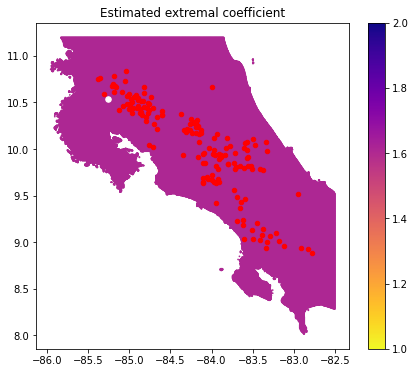

[1440, 5, 360, 10, 15, 720, 180, 120, 60, 30]
CRPS base:  0.04863356603949732
CRPS model:  0.02663735312534945


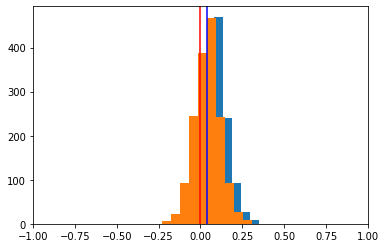

  5%|▍         | 499/10000 [00:27<02:34, 61.61it/s]

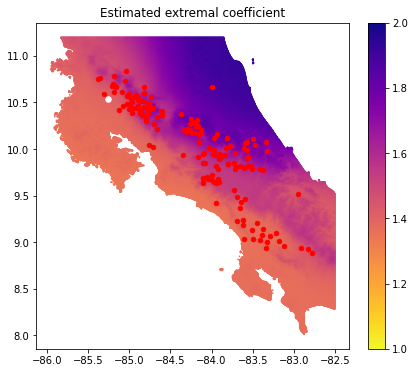

[1440, 5, 360, 10, 15, 720, 180, 120, 60, 30]
CRPS base:  0.04863356603949732
CRPS model:  0.044698142854619816


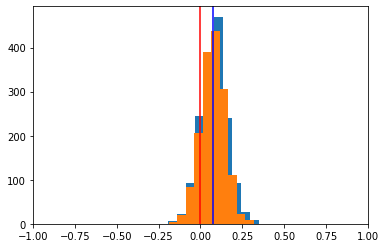

 10%|▉         | 995/10000 [00:55<02:20, 64.00it/s]

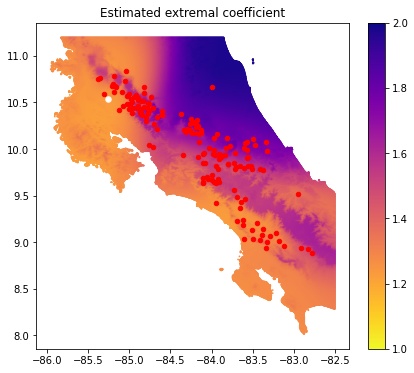

Repeating...
[1440, 5, 360, 10, 15, 720, 180, 120, 60, 30]
CRPS base:  0.04863356603949732
CRPS model:  0.0491265249574106


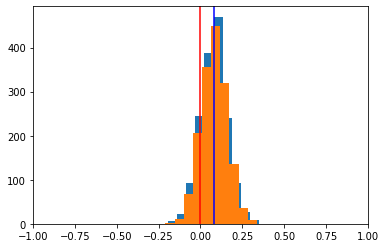

 15%|█▍        | 1499/10000 [01:23<02:13, 63.77it/s]

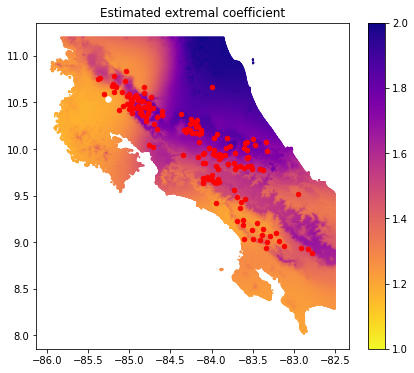

Repeating...
Repeating...
[1440, 5, 360, 10, 15, 720, 180, 120, 60, 30]
CRPS base:  0.04863356603949732
CRPS model:  0.041944843037937496


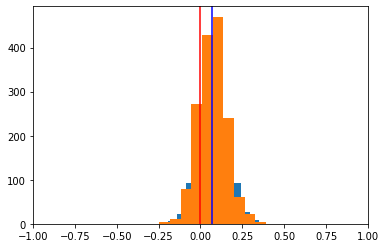

 20%|█▉        | 1994/10000 [01:50<02:20, 56.88it/s]

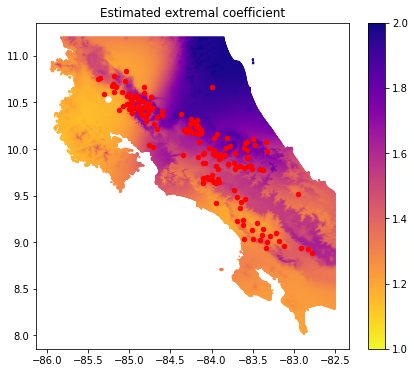

[1440, 5, 360, 10, 15, 720, 180, 120, 60, 30]
CRPS base:  0.04863356603949732
CRPS model:  0.041823910573059744


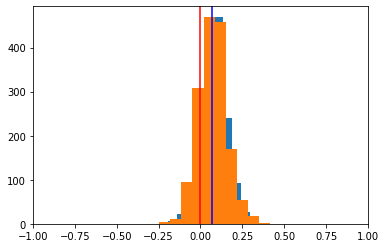

 25%|██▌       | 2500/10000 [02:18<01:57, 63.76it/s]

Repeating...


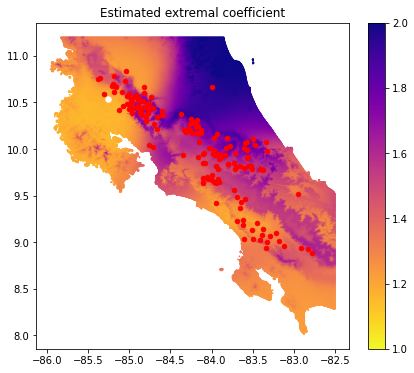

[1440, 5, 360, 10, 15, 720, 180, 120, 60, 30]
CRPS base:  0.04863356603949732
CRPS model:  0.042626535863117265


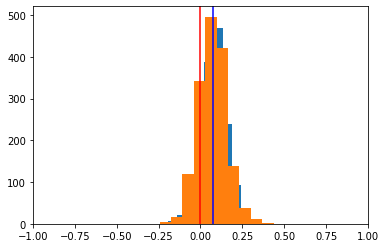

 30%|██▉       | 2994/10000 [02:46<01:57, 59.83it/s]

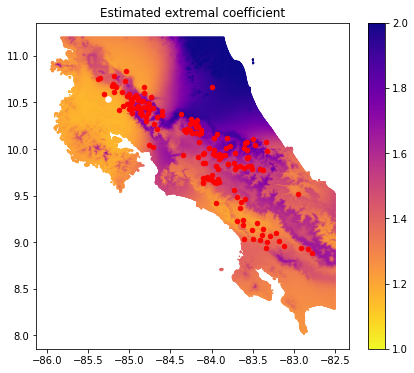

Repeating...
[1440, 5, 360, 10, 15, 720, 180, 120, 60, 30]
CRPS base:  0.04863356603949732
CRPS model:  0.044288734574610585


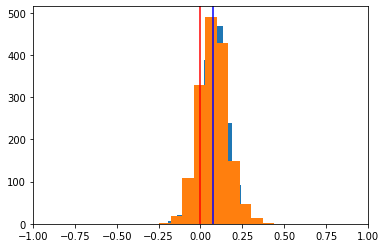

 35%|███▍      | 3495/10000 [03:14<01:40, 64.49it/s]

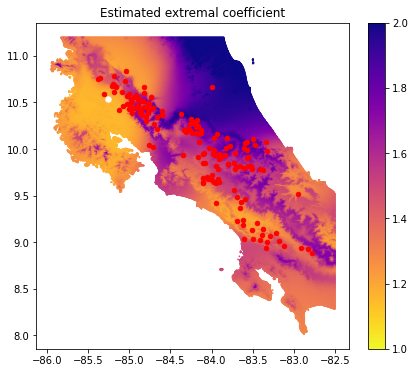

[1440, 5, 360, 10, 15, 720, 180, 120, 60, 30]


 35%|███▌      | 3500/10000 [03:33<06:37, 16.36it/s]


KeyboardInterrupt: ignored

In [ ]:
modl = bivariate_model(covariates = ["X", "Y", "alt", "dur"], 
                       model_type = "Husler-Reiss", 
                       # model_type = "negative logistic", 
                       fixed_first_covariates = False,
                       use_distance_to_scale_dependence = False)
modl.train()

Learning_rate = 0.01
decay_factor = 1
resample_training = False

optimizer = torch.optim.Adam(modl.parameters(), lr=Learning_rate)
lr_scheduler = CyclicCosAnnealingLR(optimizer, 
                                    milestones=[100, 150, 200, 250, 300, 350, 400, 450, 
                                                500, 600, 700, 800, 900, 1000, 1500, 2000, 4000, 5000, 10000, 15000, 20000], 
            eta_min = Learning_rate/decay_factor)
  
loss_training, loss_testing, loss_testing_unknown_stations, stateCheckpoint = train_model(modl, 
                optimizer, lr_scheduler, 
                sample_training, sample_testing, None, 
                nb_iterations = 10000, verbose = False, save_criterion = "train", 
                load_best_model_end = True)

In [ ]:
# plt.plot(loss_training)
# plt.show()
# plt.plot(loss_testing)
# plt.show()

In [ ]:
from tqdm import tqdm

list_models = []
Nb_time_dataset_is_recreated = 40
for b in range(Nb_time_dataset_is_recreated):
  print("-------------- Model ", b, " --------------")
  d1, d2, d3, scaler, list_stations_training = create_training_datasets(
                                      data_input = monthly_maxima_labelMonth[monthly_maxima_labelMonth["id"].isin(list_stations_training)], 
                                      train_size = Train_dataset_relative_size, 
                                      proportion_station_train = 1.0 - 0.0, 
                                      inputs_columns = inputs_columns, 
                                      name_covariates = name_covariates,
                                      seed_val = None, 
                                      station1 = Station_of_interest, 
                                      station2 = Second_station_of_interest, 
                                      duration = Duration_of_interest)
  
  sample_training = d1.getSample(15000)
  sample_testing = d2.getSample(5000)
  # sample_testing_unknown_stations = d3.getSample(5000)

  modl = bivariate_model(covariates = ["X", "Y", "alt", "dur"], 
                       model_type = "Husler-Reiss", 
                       fixed_first_covariates = True,
                       use_distance_to_scale_dependence = False)
  modl.train()

  Learning_rate = 0.01
  decay_factor = 1
  resample_training = False

  optimizer = torch.optim.Adam(modl.parameters(), lr=Learning_rate)
  lr_scheduler = CyclicCosAnnealingLR(optimizer, 
                                    milestones=[100, 150, 200, 250, 300, 350, 400, 450, 
                                                500, 600, 700, 800, 900, 1000, 1500, 2000, 4000, 5000, 10000, 15000, 20000], 
            eta_min = Learning_rate/decay_factor)
  
  loss_training, loss_testing, loss_testing_unknown_stations, stateCheckpoint = train_model(modl, 
                optimizer, lr_scheduler,                  
                sample_training, sample_testing, None, plot_evolution = False,
                nb_iterations = 3000, verbose = False, save_criterion = "train",
                load_best_model_end = False)
  
  list_models.append(modl)

-------------- Model  0  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:54<00:00, 54.91it/s]


-------------- Model  1  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:54<00:00, 54.58it/s]


-------------- Model  2  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:54<00:00, 54.90it/s]


-------------- Model  3  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:54<00:00, 54.90it/s]


-------------- Model  4  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:55<00:00, 53.58it/s]


-------------- Model  5  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:55<00:00, 54.47it/s]


-------------- Model  6  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:54<00:00, 55.25it/s]


-------------- Model  7  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:53<00:00, 55.83it/s]


-------------- Model  8  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:53<00:00, 55.64it/s]


-------------- Model  9  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:54<00:00, 54.67it/s]


-------------- Model  10  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:54<00:00, 54.98it/s]


-------------- Model  11  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:54<00:00, 54.63it/s]


-------------- Model  12  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:53<00:00, 56.10it/s]


-------------- Model  13  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:54<00:00, 54.87it/s]


-------------- Model  14  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:53<00:00, 56.02it/s]


-------------- Model  15  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:54<00:00, 55.06it/s]


-------------- Model  16  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:54<00:00, 55.40it/s]


-------------- Model  17  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:54<00:00, 54.60it/s]


-------------- Model  18  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:54<00:00, 55.22it/s]


-------------- Model  19  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:54<00:00, 55.00it/s]


-------------- Model  20  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:54<00:00, 55.42it/s]


-------------- Model  21  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:56<00:00, 52.86it/s]


-------------- Model  22  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:55<00:00, 54.50it/s]


-------------- Model  23  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:55<00:00, 54.33it/s]


-------------- Model  24  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:54<00:00, 54.55it/s]


-------------- Model  25  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:55<00:00, 54.18it/s]


-------------- Model  26  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:55<00:00, 54.22it/s]


-------------- Model  27  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:55<00:00, 53.97it/s]


-------------- Model  28  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:55<00:00, 53.67it/s]


-------------- Model  29  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:55<00:00, 54.10it/s]


-------------- Model  30  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:55<00:00, 54.28it/s]


-------------- Model  31  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:55<00:00, 54.20it/s]


-------------- Model  32  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:55<00:00, 53.87it/s]


-------------- Model  33  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:55<00:00, 54.03it/s]


-------------- Model  34  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:55<00:00, 54.08it/s]


-------------- Model  35  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:55<00:00, 53.94it/s]


-------------- Model  36  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:55<00:00, 54.47it/s]


-------------- Model  37  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:55<00:00, 54.17it/s]


-------------- Model  38  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:55<00:00, 53.63it/s]


-------------- Model  39  --------------
[0, 1, 2, 3]


100%|██████████| 3000/3000 [00:55<00:00, 54.29it/s]


In [ ]:
from os import name
from tqdm import tqdm

duration = np.log(1440)
main_station_id = Station_of_interest
assert main_station_id is not None, "Replace 'main_station_id' with some station."

locations_df = pd.read_csv("/content/drive/MyDrive/elevation_map.csv")
locations_df.drop("Unnamed: 0", inplace = True, axis=1)
locations_df.rename({"long":"X", "lat":"Y", "alt":"alt"}, inplace=True, axis=1)
locations_df = locations_df[locations_df["alt"] >= 0]
locations_df["log_duration"] = duration

locations_df.loc[:, ['X', 'Y', 'alt']] = scaler.transform(locations_df[['X', 'Y', 'alt']])
locations_df_tensor = torch.from_numpy(locations_df[["X", "Y", "alt"]].to_numpy())

outputs = []
output_a = []

ex_sample = d1.getSample(1)
sample_in1 = []
sample_in2 = []
l1 = ex_sample['input']["cov1"].float()[0,:].view(1, -1)
l1[0, 0:3] = torch.from_numpy(data_frame_station_attributes_rescaled.loc[main_station_id,:].values)
l1[0,3] = duration

for s in tqdm(range(locations_df_tensor.shape[0])):
    l2 = ex_sample['input']["cov2"].float()[0,:].view(1, -1)
    # l2[0, 0:3] = torch.from_numpy(df_input[df_input["id"] == stations_id[s]].iloc[0,0:3].values)
    l2[0, 0:3] = locations_df_tensor[s,0:3]
    l2[0,3] = duration
    sample_in1.append(l1)
    sample_in2.append(l2)

locations_df.loc[:, ['X', 'Y', 'alt']] = scaler.inverse_transform(locations_df[['X', 'Y', 'alt']])


# mean_estimate = None
estimates = []
for b, model_b in tqdm(enumerate(list_models)):
  model_b.eval()
  parameter_model = model_b.get_parameter(
    input_cov1 = torch.cat(sample_in1, axis = 0).float(), 
    input_cov2 = torch.cat(sample_in2, axis = 0).float()
    )
  estimates.append(model_b.get_extremal_coefficient(parameter_model))
  # if mean_estimate is None:
  #   mean_estimate = model_b.get_extremal_coefficient(parameter_model)
  #   min_estimate = mean_estimate
  #   max_estimate = mean_estimate
  # else:
  #   mean_estimate = mean_estimate + model_b.get_extremal_coefficient(parameter_model)
  #   min_estimate = np.minimum(min_estimate, model_b.get_extremal_coefficient(parameter_model))
  #   max_estimate = np.maximum(max_estimate, model_b.get_extremal_coefficient(parameter_model))

  model_b.train()

estimates = np.concatenate(estimates, axis = 1)

100%|██████████| 301447/301447 [00:09<00:00, 31449.80it/s]
40it [00:16,  2.50it/s]


In [ ]:
mean_estimate = np.mean(estimates, axis=1)
upper_estimate = np.quantile(estimates, 0.975, axis = 1)
lower_estimate = np.quantile(estimates, 0.025, axis = 1)

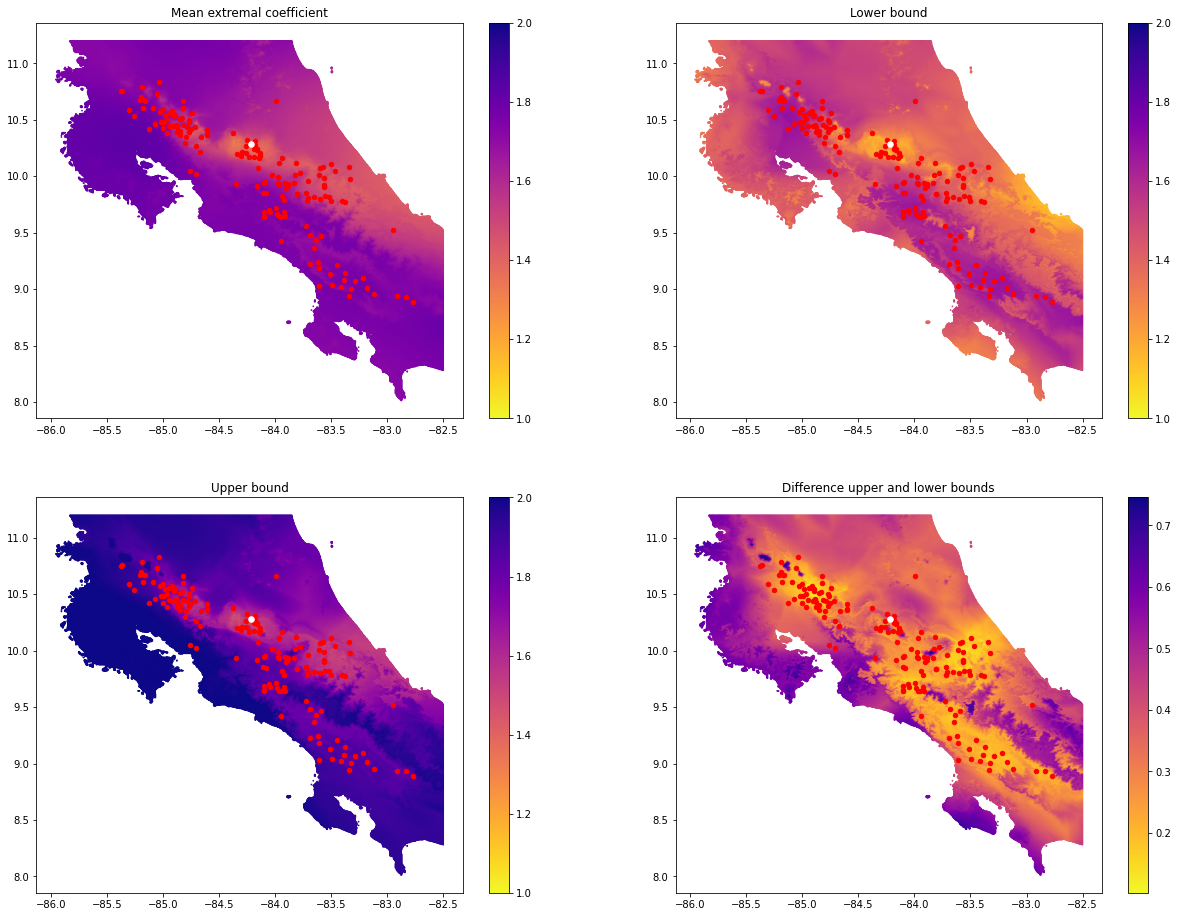

In [ ]:
import matplotlib.cm as cm
import matplotlib as mpl

# location = scaler.inverse_transform(df_input[df_input["id"] == main_station_id].iloc[:,0:3])
location = data_frame_station_attributes.loc[main_station_id,:].values

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (21,16))

im1 = ax1.scatter(locations_df['X'], locations_df['Y'], c=mean_estimate, cmap='plasma_r', s = 0.5, vmin=1, vmax=2)
fig.colorbar(im1, ax=ax1, orientation='vertical', norm = mpl.colors.Normalize(vmin=1, vmax=2))
# ax1.scatter(x = locations_training[:,0], y = locations_training[:,1], c = "blue", s = 20)
ax1.scatter(x = data_frame_station_attributes.values[:,0], y = data_frame_station_attributes.values[:,1], c = "red", s = 20)
ax1.scatter(x = location[0], y = location[1], c = "white", s = 30)
ax1.set_title("Mean extremal coefficient")

im2 = ax2.scatter(locations_df['X'], locations_df['Y'], c=lower_estimate, cmap='plasma_r', s = 0.5, vmin=1, vmax=2)
fig.colorbar(im2, ax=ax2, orientation='vertical', norm = mpl.colors.Normalize(vmin=1, vmax=2))
# ax2.scatter(x = locations_training[:,0], y = locations_training[:,1], c = "blue", s = 20)
ax2.scatter(x = data_frame_station_attributes.values[:,0], y = data_frame_station_attributes.values[:,1], c = "red", s = 20)
ax2.scatter(x = location[0], y = location[1], c = "white", s = 30)
ax2.set_title("Lower bound")

im3 = ax3.scatter(locations_df['X'], locations_df['Y'], c=upper_estimate, cmap='plasma_r', s = 0.5, vmin=1, vmax=2)
fig.colorbar(im3, ax=ax3, orientation='vertical', norm = mpl.colors.Normalize(vmin=1, vmax=2))
# ax3.scatter(x = locations_training[:,0], y = locations_training[:,1], c = "blue", s = 20)
ax3.scatter(x = data_frame_station_attributes.values[:,0], y = data_frame_station_attributes.values[:,1], c = "red", s = 20)
ax3.scatter(x = location[0], y = location[1], c = "white", s = 30)
ax3.set_title("Upper bound")

im4 = ax4.scatter(locations_df['X'], locations_df['Y'], c=upper_estimate - lower_estimate, cmap='plasma_r', s = 0.5)
fig.colorbar(im4, ax=ax4, orientation='vertical')
# ax4.scatter(x = locations_training[:,0], y = locations_training[:,1], c = "blue", s = 20)
ax4.scatter(x = data_frame_station_attributes.values[:,0], y = data_frame_station_attributes.values[:,1], c = "red", s = 20)
ax4.scatter(x = location[0], y = location[1], c = "white", s = 30)
ax4.set_title("Difference upper and lower bounds")

plt.show()

In [ ]:
df = locations_df.copy()
df['mean'] = mean_estimate
df['upper'] = upper_estimate
df['lower'] = lower_estimate
df

,X,Y,alt,log_duration,mean,upper,lower
40,-85.831250,11.197917,13.0,7.272398,1.728835,1.977536,1.392831
41,-85.827083,11.197917,31.0,7.272398,1.728496,1.979706,1.391729
42,-85.822917,11.197917,69.0,7.272398,1.727797,1.983323,1.387656
43,-85.818750,11.197917,86.0,7.272398,1.727462,1.984408,1.386594
44,-85.814583,11.197917,40.0,7.272398,1.728256,1.979994,1.394895
...,...,...,...,...,...,...,...
640830,-82.872917,8.022917,0.0,7.272398,1.718918,1.944568,1.348487
641668,-82.881250,8.018750,15.0,7.272398,1.718351,1.945669,1.343285
641669,-82.877083,8.018750,22.0,7.272398,1.718413,1.945718,1.344139
642509,-82.877083,8.014583,15.0,7.272398,1.718206,1.945696,1.343043


In [ ]:
df.to_csv("/content/drive/MyDrive/pred_model_bivariate_69507_full.csv", index=False)

In [ ]:
from os import name
from tqdm import tqdm

durations = list(set(monthly_maxima_labelMonth["dur"]))

main_station_id = Station_of_interest
assert main_station_id is not None, "Replace 'main_station_id' with some station."

modl.eval()
stations2 = list(set(monthly_maxima_labelMonth["id"]))

def get_empirical_extremal_coefficient(DF, s1, s2, duration, ref_lab = "id", quantity_lab = "int_frechet"):
  df = DF[(DF[ref_lab] == s1) | (DF[ref_lab] == s2)]
  total_lab = ["month", "year", "dur"]
  total_lab.append(quantity_lab)
  df1 = df[(df[ref_lab] == s1)].loc[:,total_lab]
  df2 = df[(df[ref_lab] == s2)].loc[:,total_lab]
  df = pd.merge(df1, df2, on = ("month", "year", "dur"))

  if len(df) > 0:
    df_ = df[(df["dur"] == duration)]
    x = 1/df_["int_frechet_x"]
    y = 1/df_["int_frechet_y"]
    return 1/np.mean(np.minimum(x, y))
  return None

result = []
for dur in tqdm(range(len(durations))):
  for s1 in [main_station_id]:
    for s2 in stations2:
      l1 = ex_sample['input']["cov1"].float()[0,:].view(1, -1)
      l1[0, 0:3] = torch.from_numpy(data_frame_station_attributes_rescaled.loc[s1,:].values)
      l1[0,3] = np.log(durations[dur])
  
      l2 = ex_sample['input']["cov2"].float()[0,:].view(1, -1)
      l2[0, 0:3] = torch.from_numpy(data_frame_station_attributes_rescaled.loc[s2,:].values)
      l2[0,3] = np.log(durations[dur])

      empirical_V = get_empirical_extremal_coefficient(monthly_maxima_labelMonth, s1, s2, duration = durations[dur])

      sample_in1.append(l1)
      sample_in2.append(l2)

      estimates = []
      for b, model_b in enumerate(list_models):
        model_b.eval()
        parameter_model = model_b.get_parameter(
          input_cov1 = torch.cat([l1], axis = 0).float(), 
          input_cov2 = torch.cat([l2], axis = 0).float()
        )
        estimates.append(model_b.get_extremal_coefficient(parameter_model))
      estimates = np.concatenate(estimates, axis = 1)

      result.append([durations[dur], s1, s2, np.mean(estimates, axis=1)[0], 
                     np.quantile(estimates, 0.975, axis = 1)[0], 
                     np.quantile(estimates, 0.025, axis = 1)[0],
                     empirical_V])

100%|██████████| 10/10 [00:53<00:00,  5.36s/it]


In [ ]:
res = pd.DataFrame(result, columns = ['dur', 's1', 's2', 'mean', 'upper', 'lower', 'empirical'])
res.to_csv("/content/drive/MyDrive/pred_model_bivariate_69507_full_stations.csv", index=False)

NameError: ignored

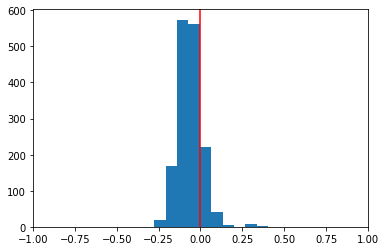

In [ ]:
plt.hist(np.vstack(np.array(np.log(res["mean"]) - np.log(res["empirical"]))), bins = 10)
# plt.hist(np.vstack(np.array(all_values)), bins = 10)
plt.xlim(-1, 1)
plt.axvline(x = 0, color = "red")
plt.axvline(x = np.mean(np.vstack(all_values)), color = "blue")
plt.show()

In [ ]:
def compare_extremal_coefficient(model, main_station_id, durations = None):
  def empirical_extremal_coefficient(DF, s1, s2, ref_lab = "id", quantity_lab = "int_frechet"):
    df = DF[(DF[ref_lab] == s1) | (DF[ref_lab] == s2)]
    total_lab = ["month", "year", "dur"]
    total_lab.append(quantity_lab)
    df1 = df[(df[ref_lab] == s1)].loc[:,total_lab]
    df2 = df[(df[ref_lab] == s2)].loc[:,total_lab]
    df = pd.merge(df1, df2, on = ("month", "year", "dur"))
    return df

  import warnings
  warnings.filterwarnings("ignore")

  d1, d2, d3, scaler, list_stations_training = create_training_datasets(
                                      data_input = monthly_maxima_labelMonth, 
                                      train_size = Train_dataset_relative_size, 
                                      proportion_station_train = 1.0 - Proportion_of_stations_test, 
                                      inputs_columns = inputs_columns, 
                                      name_covariates = name_covariates,
                                      seed_val = 42, 
                                      station1 = Station_of_interest, 
                                      station2 = Second_station_of_interest, 
                                      duration = Duration_of_interest)

  ex_sample = d1.getSample(1)

  model.eval()
  stations2 = list(set(monthly_maxima_labelMonth["id"]))
  if durations is None:
    durations = list(set(monthly_maxima_labelMonth["dur"]))
  # durations = [5]
  print(durations)

  empirical_V = {}
  fitted_V = {}
  for s1 in [main_station_id]:
    for s2 in stations2:
      if s1 == s2: continue
      df = empirical_extremal_coefficient(monthly_maxima_labelMonth, s1, s2)
      for du in durations:

        # Empirical V(1,1)
        if len(df) > 0:
          df_ = df[(df["dur"] == du)]
          x = 1/df_["int_frechet_x"]
          y = 1/df_["int_frechet_y"]
          empirical_V[(s1, s2, du)] = 1/np.mean(np.minimum(x, y))

        # fitted V(1,1)
        l1 = ex_sample['input']["cov1"].float()[0,:].view(1, -1)
        l1[0, 0:3] = torch.from_numpy(data_frame_station_attributes_rescaled.loc[s1,:].values)
        l1[0,3] = np.log(du)
  
        l2 = ex_sample['input']["cov2"].float()[0,:].view(1, -1)
        l2[0, 0:3] = torch.from_numpy(data_frame_station_attributes_rescaled.loc[s2,:].values)
        l2[0,3] = np.log(du)

        parameter_model = model.get_parameter(
              input_cov1 = torch.cat([l1], axis = 0).float(), 
              input_cov2 = torch.cat([l2], axis = 0).float()
              )
        fitted_V[(s1, s2, du)] = model.get_extremal_coefficient(parameter_model)

  model.train()

  all_values_1 = []
  all_values = []
  for key, val in fitted_V.items():
    if key in empirical_V.keys():
      all_values.append(np.log(empirical_V[key]) - np.log(fitted_V[key]))
      all_values_1.append(np.log(empirical_V[key]) - np.log(1.55))

  print("CRPS base: ", CRPS_score(np.array(all_values_1), 0.0))
  print("CRPS model: ", CRPS_score(np.array(all_values), 0.0))

  plt.hist(np.vstack(np.array(all_values_1)), bins = 10)
  plt.hist(np.vstack(np.array(all_values)), bins = 10)
  plt.xlim(-1, 1)
  plt.axvline(x = 0, color = "red")
  plt.axvline(x = np.mean(np.vstack(all_values)), color = "blue")
  plt.show()


In [ ]:
def CRPS_score(array_pred, x):
  m = len(array_pred)
  term1 = np.mean(abs(array_pred - x))
  term2 = np.sum(np.abs(np.subtract.outer(array_pred, array_pred).reshape(-1, 1)))/(2*m**2)
  return term1 - term2

In [ ]:
def empirical_extremal_coefficient(DF, s1, s2, ref_lab = "id", quantity_lab = "int_frechet"):
  df = DF[(DF[ref_lab] == s1) | (DF[ref_lab] == s2)]
  total_lab = ["month", "year", "dur"]
  total_lab.append(quantity_lab)
  df1 = df[(df[ref_lab] == s1)].loc[:,total_lab]
  df2 = df[(df[ref_lab] == s2)].loc[:,total_lab]
  df = pd.merge(df1, df2, on = ("month", "year", "dur"))
  return df

import warnings
warnings.filterwarnings("ignore")

modl.eval()
stations2 = list(set(monthly_maxima_labelMonth["id"]))
durations = list(set(monthly_maxima_labelMonth["dur"]))
# durations = [5]
print(durations)

empirical_V = {}
fitted_V = {}
for s1 in [main_station_id]:
  for s2 in tqdm(stations2):
    if s1 == s2: continue
    df = empirical_extremal_coefficient(monthly_maxima_labelMonth, s1, s2)
    for du in durations:

      # Empirical V(1,1)
      if len(df) > 0:
        df_ = df[(df["dur"] == du)]
        x = 1/df_["int_frechet_x"]
        y = 1/df_["int_frechet_y"]
        empirical_V[(s1, s2, du)] = 1/np.mean(np.minimum(x, y))

      # fitted V(1,1)
      l1 = ex_sample['input']["cov1"].float()[0,:].view(1, -1)
      l1[0, 0:3] = torch.from_numpy(data_frame_station_attributes_rescaled.loc[s1,:].values)
      l1[0,3] = np.log(du)
  
      l2 = ex_sample['input']["cov2"].float()[0,:].view(1, -1)
      l2[0, 0:3] = torch.from_numpy(data_frame_station_attributes_rescaled.loc[s2,:].values)
      l2[0,3] = np.log(du)

      mean_val = 0.0
      for b, model_b in enumerate(list_models):
        model_b.eval()
        with torch.no_grad():
          parameter_model = model_b.get_parameter(
              input_cov1 = torch.cat([l1], axis = 0).float(), 
              input_cov2 = torch.cat([l2], axis = 0).float()
              )
          mean_val = mean_val + model_b.get_extremal_coefficient(parameter_model)
      fitted_V[(s1, s2, du)] = mean_val/len(list_models)

[1440, 5, 360, 10, 15, 720, 180, 120, 60, 30]


100%|██████████| 160/160 [00:26<00:00,  6.00it/s]


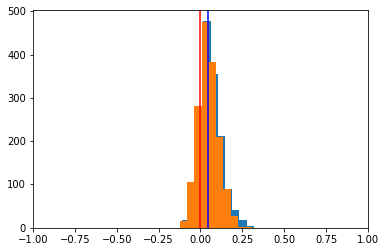

In [ ]:
all_values_1 = []
all_values = []
for key, val in fitted_V.items():
  if key in empirical_V.keys():
    # all_values.append(empirical_V[key] - fitted_V[key])
    all_values.append(np.log(empirical_V[key]) - np.log(fitted_V[key]))
    all_values_1.append(np.log(empirical_V[key]) - np.log(1.55))

plt.hist(np.vstack(all_values_1), bins = 10)
plt.hist(np.vstack(all_values), bins = 10)
plt.xlim(-1, 1)
plt.axvline(x = 0, color = "red")
plt.axvline(x = np.mean(np.vstack(all_values)), color = "blue")
plt.show()